# Sprint 15 Project: Age Determination for Alcohol Usage

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage.

### Stages:
1. Data Preprocessing: Clean and organize the data, ensuring it's ready for analysis.
2. Exploratory Data Analysis (EDA): Perform an initial analysis to understand the data distribution and identify key trends.
3. ID Target/Feature Variables: Find out exactly what variable is being tested.
4. Determine Best Model: Train, fine tune, & evaluate the appropriate models for the task.

## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

## EDA

In [1]:
image_path = '/datasets/faces/final_files/'
labels_path = '/datasets/faces/labels.csv'

### Initial Look at Dataset Size

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator


labels = pd.read_csv(labels_path)

In [3]:
display(labels.head())
display(labels.shape)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


(7591, 2)

Looking at the dimensions of the dataset, there seems to be 2 columns & 7,591 rows that comprise it.:
- <b>Column 1:</b> holds the name of the image files
- <b>Column 2:</b> holds the age of the the individual represent within the image file

### Exploring the distribution of the 'real_age' variable

 Descriptive Stats:


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


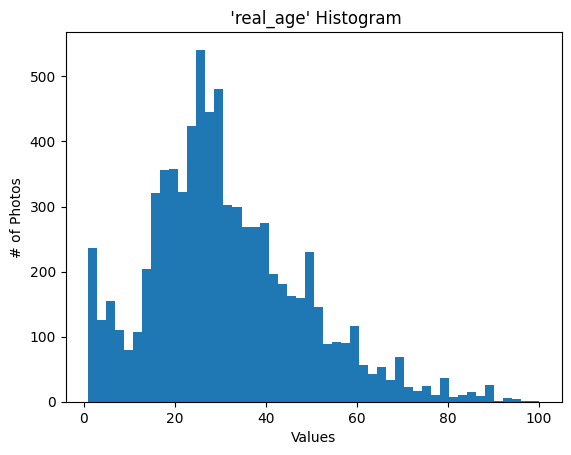

In [4]:
import matplotlib.pyplot as plt
print(" Descriptive Stats:")
display(labels.describe())

plt.hist(labels['real_age'], bins=50)
plt.title(" 'real_age' Histogram")
plt.xlabel('Values')
plt.ylabel('# of Photos')
plt.show()

Looking at the descriptive statistics of the 'real_age' variable, the mean value (31) is slightly larger than the median value (29). This indicates that the distribution is positively skewed, given that the relationship between the mean, median and mode in a perfectly normal distribution is: mean=median=mode.

This is depicted visually in the above histogram.

### 10 Randomly Selected Photos

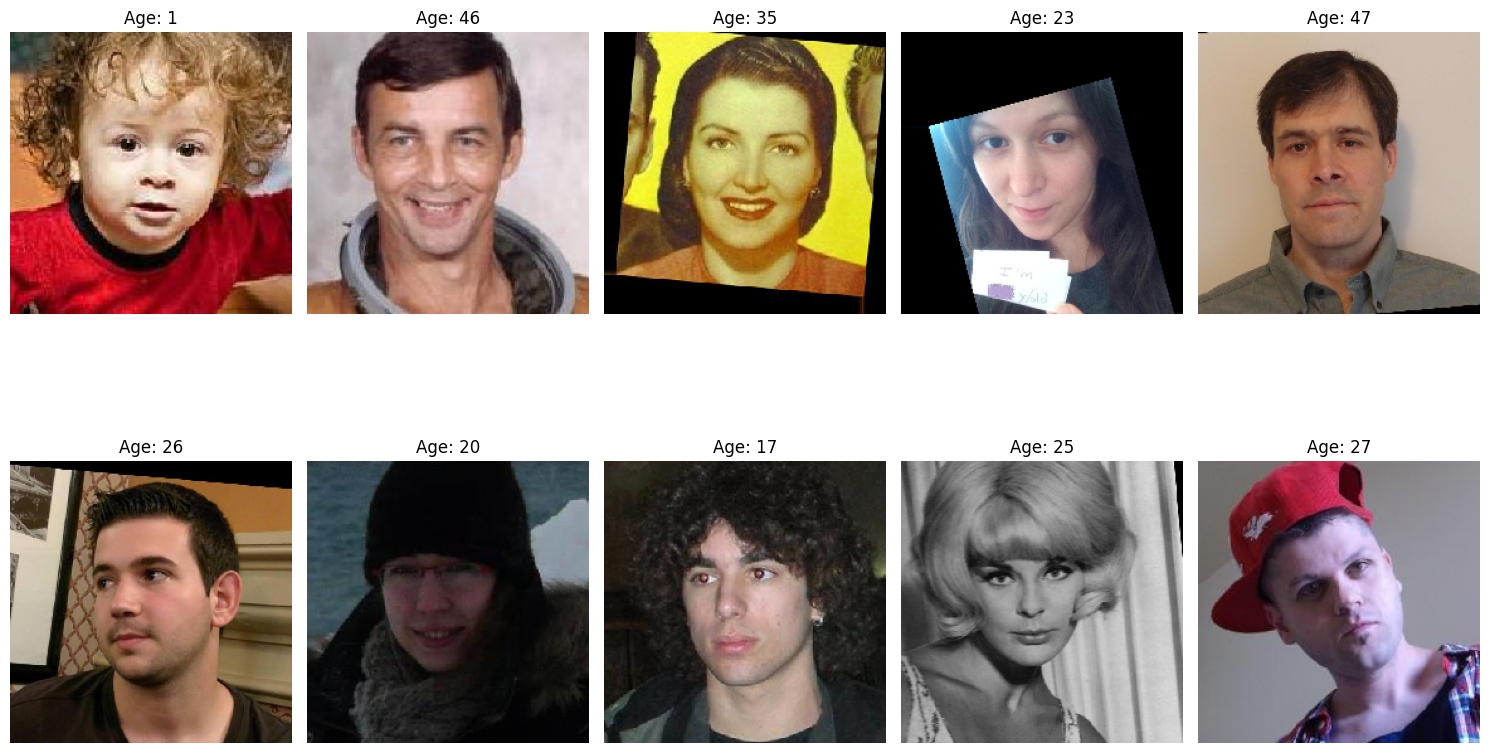

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

# sample a few images
sample_images = labels.sample(n=10, random_state=42)

# plot the images
plt.figure(figsize=(15, 10))
for idx, row in enumerate(sample_images.itertuples(), 1):
    img = load_img(f"/datasets/faces/final_files/{row.file_name}", target_size=(224, 224))
    plt.subplot(2, 5, idx)
    plt.imshow(img)
    plt.title(f"Age: {row.real_age}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Findings

After looking at the photos generated, it seems that the unique lighting & angle of each face may affect how accurate the model is trained. Also, some individuals have headwear/eyeglasses on & present various facial expressions, which may interfere with training as well.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [6]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [7]:
def load_train(path):

    """
    It loads the train part of dataset from path
    """
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
          dataframe=labels,
          directory=image_path,
          x_col='file_name',
          y_col='real_age',
          target_size=(224, 224),
          batch_size=32,
          class_mode='raw',
          subset='training',
          seed=12345)

    return train_gen_flow

In [8]:
train_gen_flow = load_train(image_path)

Found 5694 validated image filenames.


In [9]:
def load_test(path):

    """
    It loads the validation/test part of dataset from path
    """
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0 / 255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=image_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [10]:
test_data = load_test(image_path)

Found 1897 validated image filenames.


In [11]:
def create_model(input_shape):

    """
    It defines the model
    """

    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [12]:
def train_model(model, train_data, test_data, batch_size=4, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)


    return model

In [ ]:
# Example usage
model = create_model(input_shape=(224, 224, 3))
# Assuming you have test_data generator defined similarly to train_data
trained_model = train_model(model, train_gen_flow, test_data, epochs=20)

2025-02-05 06:07:19.161598: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20


## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:

    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

``` python
Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512
```

## Model Analysis/Conclusions

After looking over the neural network's training over 20 epochs, it is observed that the model learns effectively from the training data, as shown by the significant drop in training loss from 95.35 to 17.02 and a decrease in mean absolute error (MAE) from 7.43 to 3.17. However, the validation metrics is concerning: the validation loss decreases to 78.44 at epoch 17 but then increases to 93.41 by epoch 20, with the validation MAE following a similar pattern. This indicates that the model is overfitting (it performs well on the training data but fails to generalize to new, unseen data).

Consequently, it is not recommended deploying the model in its current form. To improve it, we applying early stopping to prevent overtraining, using regularization techniques like L1/L2 regularization and dropout layers to reduce complexity, adjusting the learning rate for better convergence, simplifying the model architecture, and ensuring the data is properly prepared and representative. These adjustments should enhance the model's ability to generalize, making it more reliable and effective for practical applications.

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training